In [1]:
#!pip install lightgbm

import os
import time
import ast
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint, uniform, loguniform
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV
from lightgbm import LGBMClassifier

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, ParameterSampler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

os.environ['PYTHONIOENCODING'] = 'utf-8'
os.environ["LOKY_MAX_CPU_COUNT"] = "4"
warnings.simplefilter(action='ignore', category=FutureWarning)

# ziarno
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Przygotowanie ramek

In [2]:
personality = pd.read_csv("personality.csv")
heart = pd.read_csv("heart.csv")
loan = pd.read_csv("loan.csv")
machine = pd.read_csv("machine.csv")

# Usuwamy zbędne kolumny z zestawu danych loan: name (z jasnych przyczyn), city (z powodu 1882 unikalnych wartości) i points (bo bezpośrednio zdradza nam czy otrzymano kredyt >60).
loan = loan.drop(columns=['name', 'city', 'points'])
personality = personality.rename(columns={'Personality': 'Introverted'})

datasets = {
    "Personality": personality,
    "Heart": heart,
    "Loan": loan,
    "Machine": machine
}

In [3]:
def prepare_data(df):
    df = df.copy().dropna()
    
    binary_map = {"Yes": 1, "No": 0, True: 1, False: 0, "Introvert": 1, "Extrovert": 0}
    df = df.replace(binary_map)
    df = pd.get_dummies(df, drop_first=False)
    
    known_targets = ["HeartDisease", "loan_approved", "Introverted", "fail"]
    target_col = next(col for col in df.columns if col in known_targets)
    y = df[target_col]
    X = df.drop(columns=[target_col], errors="ignore")
    X = X.astype(float)#
    y = y.astype(int)

    print(f"\n Dane po przygotowaniu ({target_col}):")
    print("X shape:", X.shape, "| y shape:", y.shape)
    print("y value counts:", dict(pd.Series(y).value_counts()))
    print(X.head(3))
    print(y.head(3))

    return train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)


In [4]:
# Przypisanie danych

X_train_personality, X_test_personality, y_train_personality, y_test_personality = prepare_data(personality)

X_train_heart, X_test_heart, y_train_heart, y_test_heart = prepare_data(heart)

X_train_loan, X_test_loan, y_train_loan, y_test_loan = prepare_data(loan)

X_train_machine, X_test_machine, y_train_machine, y_test_machine = prepare_data(machine)

# nie mamy bardzo nierównych klas, najbardziej nierówna jest 551 do 393 (58% do 42%)


 Dane po przygotowaniu (Introverted):
X shape: (2900, 7) | y shape: (2900,)
y value counts: {0: 1491, 1: 1409}
   Time_spent_Alone  Stage_fear  Social_event_attendance  Going_outside  \
0               4.0         0.0                      4.0            6.0   
1               9.0         1.0                      0.0            0.0   
2               9.0         1.0                      1.0            2.0   

   Drained_after_socializing  Friends_circle_size  Post_frequency  
0                        0.0                 13.0             5.0  
1                        1.0                  0.0             3.0  
2                        1.0                  5.0             2.0  
0    0
1    1
2    1
Name: Introverted, dtype: int32

 Dane po przygotowaniu (HeartDisease):
X shape: (918, 20) | y shape: (918,)
y value counts: {1: 508, 0: 410}
    Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  Sex_F  Sex_M  \
0  40.0      140.0        289.0        0.0  172.0      0.0    0.0    1.0   


In [5]:
# Lista datasetów
datasets_full = {
    'personality': (X_train_personality, y_train_personality, X_test_personality, y_test_personality),
    'Heart': (X_train_heart, y_train_heart, X_test_heart, y_test_heart),
    'Loan': (X_train_loan, y_train_loan, X_test_loan, y_test_loan),
    'Machine': (X_train_machine, y_train_machine, X_test_machine, y_test_machine)
}

## Klasyfikacja przestrzeni parametrów


In [6]:
# Różne siatki żeby mieć różne typy danych do różnych bibliotek

param_space_rs = {
    'num_leaves': randint(20, 150),
    'max_depth': randint(8, 15), # Zmienione
    'learning_rate': loguniform(0.001, 0.3), # mniejszy -> wolniejszy ale stabilniejszy
    'n_estimators': randint(50, 5000),
    'min_child_samples': randint(1, 100),
    'subsample': uniform(0.6, 0.4), # zmienione
    'colsample_bytree': uniform(0.6, 0.4), # zmienione
}

param_space_bayes = {
    'n_estimators': Integer(50, 5000),
    'learning_rate': Real(0.001, 0.3, prior='log-uniform'),
    'num_leaves': Integer(20, 150),
    'subsample': Real(0.1, 1.0),
    'max_depth': Integer(1, 15),
    'min_child_samples': Integer(1, 100),
    'colsample_bytree': Real(0.1, 1.0),
}

In [7]:
# Liczba losowych zestawów hiperparametrów
n_param_sets = 100
# zestawy parametrów
param_samples = list(ParameterSampler(param_space_rs, n_iter=n_param_sets, random_state=42)) 

# - Random search

In [8]:
# #### Nie odpalać, są pliki do pobrania

# start = time.time()
# results_random = []

# for i, params in enumerate(param_samples):
#     scores = []
    
#     # Testujemy zestaw na wszystkich zbiorach
#     for name, (X_train, y_train, X_test, y_test) in datasets_full.items():
#         model = LGBMClassifier(**params, verbose=-1) # Rozpakowanie słownika
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
        
#         f1 = f1_score(y_test, y_pred)
#         scores.append(f1)
#         results_random.append({
#             'Dataset': name,
#             'Param_set': i+1,
#             'F1_score': f1,
#             **params
#         })
    
#     # Po przejściu wszystkich datasetów
#     avg_f1 = np.mean(scores)

# end = time.time()
# print("Czas wykonania:", end - start, "sekundy")

# ### Średnie wartości per set
# # Obliczamy średni F1 dla każdego zestawu parametrów
# avg_scores = (
#     df_random
#     .groupby('Param_set', as_index=False)['F1_score']
#     .mean()
#     .rename(columns={'F1_score': 'Avg_F1'})
# )

# # Dołączamy średni wynik do głównej tabeli
# results_with_avg = df_random.merge(avg_scores, on='Param_set')

# #### Zapisanie wyników random
# df_random = pd.DataFrame(results_random)
# df_random.to_csv("df_random.csv", index=False)

# avg_scores.to_csv("avg_scores.csv", index=False)
# df_random_avg.to_csv("results_with_avg.csv", index=False)


In [9]:
#### Wczytanie danych
df_random = pd.read_csv("df_random.csv")
avg_scores = pd.read_csv("avg_scores.csv")
df_random_avg = pd.read_csv("df_random_avg.csv")
df_random_avg.head()

,Dataset,Param_set,F1_score,colsample_bytree,learning_rate,max_depth,min_child_samples,n_estimators,num_leaves,subsample,Avg_F1
0,personality,1,0.879532,0.749816,0.226482,10,72,3822,40,0.662407,0.896627
1,Heart,1,0.867550,0.749816,0.226482,10,72,3822,40,0.662407,0.896627
2,Loan,1,0.977358,0.749816,0.226482,10,72,3822,40,0.662407,0.896627
3,Machine,1,0.862069,0.749816,0.226482,10,72,3822,40,0.662407,0.896627
4,personality,2,0.917538,0.662398,0.001393,12,24,180,72,0.987964,0.855343


In [10]:
# ranking zestawów po średnim F1:
ranking = avg_scores.sort_values('Avg_F1', ascending=False)
print("\nRanking zestawów:")
print(ranking)

# Identyfikacja najlepszego zestawu
best_param_set_id = ranking.iloc[0]['Param_set']


Ranking zestawów:
    Param_set    Avg_F1
4           5  0.929150
43         44  0.928606
21         22  0.928528
91         92  0.926283
39         40  0.926083
..        ...       ...
36         37  0.894357
63         64  0.893603
68         69  0.890218
1           2  0.855343
51         52  0.824097

[100 rows x 2 columns]


# - Bayes

In [11]:
# #### Nie odpalać, są dane do pobrania

# bayes_search = BayesSearchCV(
#     estimator=LGBMClassifier(verbose=-1),
#     search_spaces=param_space_bayes,
#     scoring='f1',
#     n_iter=50,         # liczba prób (mniej niż w random, tam było 100)
#     cv=3,
#     n_jobs=-1,
#     random_state=42
# )

# results_bayes = []
# results_cv_all = []

# start = time.time()

# for name, (X_train, y_train, X_test, y_test) in datasets_full.items():
#     print(f"\n=== BayesSearch dla zbioru: {name} ===")
#     bayes_search.fit(X_train, y_train)
    
#     y_pred = bayes_search.predict(X_test)
#     f1 = f1_score(y_test, y_pred)
    
#     results_bayes.append({
#         'Dataset': name,
#         'Best_F1': f1,
#         'Best_params': bayes_search.best_params_
#     })

#     cv_df = pd.DataFrame(bayes_search.cv_results_)
#     cv_df["Dataset"] = name  # dodajesz nazwę zbioru
    
#     results_cv_all.append(cv_df)

# end = time.time()
# print("Czas wykonania:", end - start, "sekundy")

# df_bayes = pd.DataFrame(results_bayes)
# df_bayes_cv = pd.concat(results_cv_all, ignore_index=True)

# #### Zapisanie wyników bayes
# df_bayes.to_csv("df_bayes.csv", index=False)
# df_bayes_cv.to_csv("df_bayes_cv.csv", index=False)

In [12]:
#### Wczytanie danychd
df_bayes = pd.read_csv("df_bayes.csv")
df_bayes_cv = pd.read_csv("df_bayes_cv.csv")

# - Baseline - bez tunowania

In [13]:
results_baseline = []

for name, (X_train, y_train, X_test, y_test) in datasets_full.items():
    model = LGBMClassifier(verbose=-1)  # oryginalne hiperparametry
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    results_baseline.append({'Dataset': name, 'Baseline_F1': f1})

df_baseline = pd.DataFrame(results_baseline)
print("=== Wyniki F1 bez tunowania ===")
print(df_baseline)


=== Wyniki F1 bez tunowania ===
       Dataset  Baseline_F1
0  personality     0.918981
1        Heart     0.894040
2         Loan     0.971319
3      Machine     0.887029


## Porównanie pierwszych wyników

In [14]:
df_random_subset = df_random.loc[df_random['Param_set'] == 5, ['Dataset', 'F1_score']]
comparison = pd.merge(
    df_baseline[['Dataset', 'Baseline_F1']],
    df_random_subset,
    on='Dataset'
)

comparison = pd.merge(
    comparison,
    df_bayes[['Dataset', 'Best_F1']],
    on='Dataset'
)

# Zmiana nazwy kolumn
comparison.rename(columns={'Best_F1': 'Bayes_F1'}, inplace=True)
comparison.rename(columns={'F1_score': 'Random_F1'}, inplace=True)

comparison_T = comparison.set_index('Dataset').T

print(comparison_T)

Dataset      personality     Heart      Loan   Machine
Baseline_F1     0.918981  0.894040  0.971319  0.887029
Random_F1       0.918794  0.919614  0.975238  0.902954
Bayes_F1        0.918794  0.915584  0.973077  0.912000


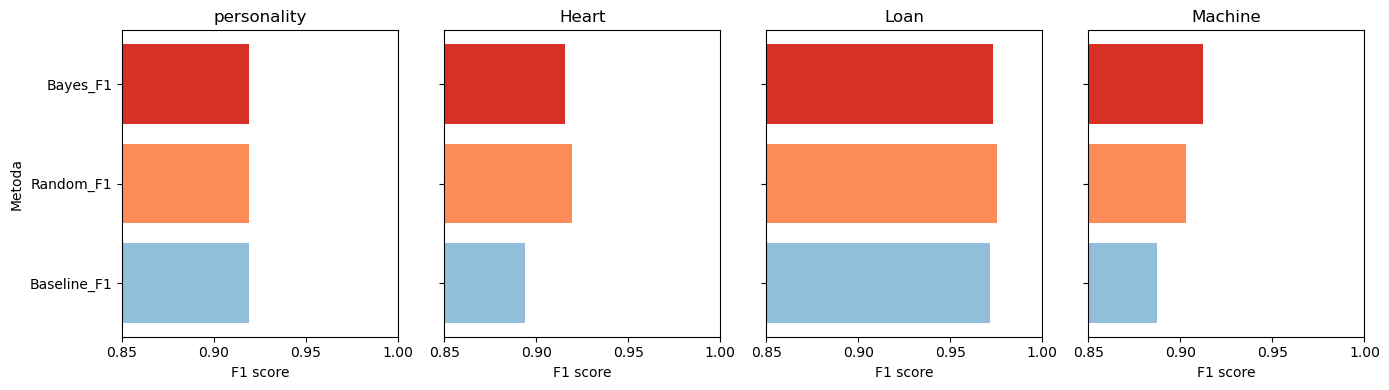

In [15]:
fig, axes = plt.subplots(1, len(comparison_T.columns), figsize=(14,4), sharey=True)

for i, dataset in enumerate(comparison_T.columns):
    axes[i].barh(comparison_T.index, comparison_T[dataset], color=['#91bfdb', '#fc8d59', '#d73027'])
    axes[i].set_title(dataset)
    axes[i].set_xlabel("F1 score")
    axes[i].set_xlim(0.85, 1.0)  # Wyświetlenie tylko końcówki
    if i == 0:
        axes[i].set_ylabel("Metoda")

# Pobieranie
plt.tight_layout()
plt.savefig("bestLightGBM.png", dpi=300, bbox_inches='tight')
plt.show()

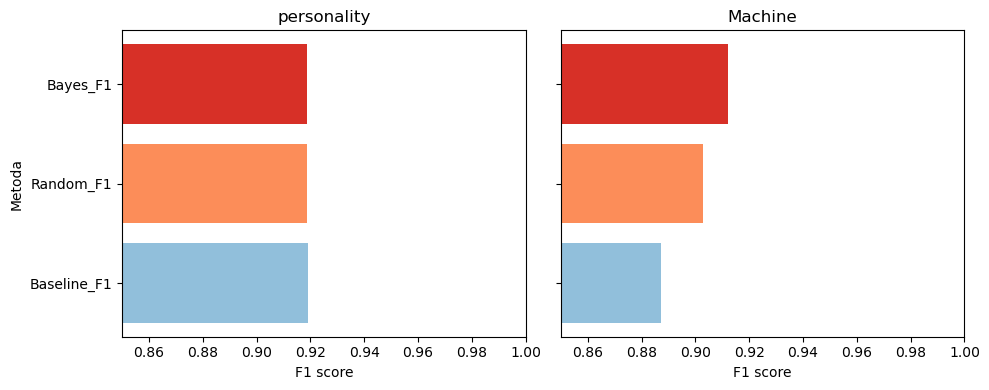

In [16]:
# Wybieramy tylko kolumny Personality i Machine do Overleaf
datasets_to_plot = ['personality', 'Machine']
comparison_subset = comparison_T[datasets_to_plot]

fig, axes = plt.subplots(1, len(datasets_to_plot), figsize=(10,4), sharey=True)

for i, dataset in enumerate(datasets_to_plot):
    axes[i].barh(comparison_subset.index, comparison_subset[dataset], color=['#91bfdb', '#fc8d59', '#d73027'])
    axes[i].set_title(dataset)
    axes[i].set_xlabel("F1 score")
    axes[i].set_xlim(0.85, 1.0)
    if i == 0:
        axes[i].set_ylabel("Metoda")

# Pobieranie
plt.tight_layout()
plt.savefig("bestLightGBM2sety.png", dpi=300, bbox_inches='tight')
plt.show()

Co po pierwszych wynikach?

Zbadać stabilizajce - może mam za mało iteracji jesli się nie stabilizuje

Zweryfikować czy mam dobre zakresy parametrów - max_depth widzę że muszę zwiększyć

Wstępna analiza wyników

## Badanie stabilizacji

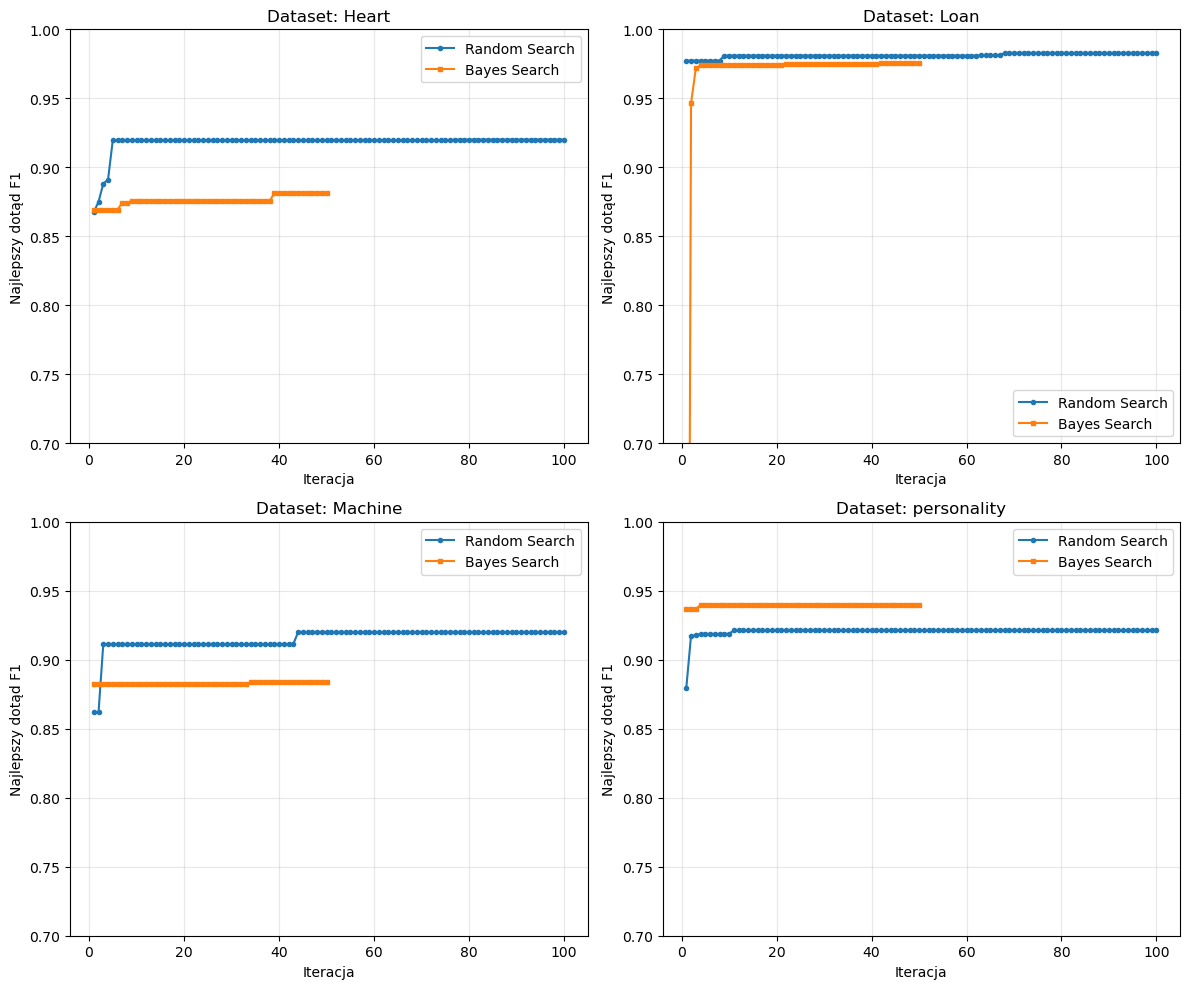

In [27]:
import matplotlib.pyplot as plt
df_bayes_cv['iteration'] = df_bayes_cv.groupby('Dataset').cumcount() + 1

df_random = df_random.sort_values(['Dataset', 'Param_set'])
df_bayes_cv = df_bayes_cv.sort_values(['Dataset', 'iteration'])

datasets = df_random['Dataset'].unique()  # lista datasetów

plt.figure(figsize=(12, 10))

for i, ds in enumerate(datasets, 1):
    plt.subplot(2, 2, i)  # 2x2 wykresy
    
    # Random Search
    sub_random = df_random[df_random['Dataset'] == ds].copy()
    sub_random['CumBest'] = sub_random['F1_score'].cummax()
    plt.plot(sub_random['Param_set'], sub_random['CumBest'], marker='o', ms=3, label='Random Search')
    plt.ylim(0.5, 1)
    
    # BayesSearchCV
    sub_bayes = df_bayes_cv[df_bayes_cv['Dataset'] == ds].copy()
    sub_bayes['cum_best'] = sub_bayes['mean_test_score'].cummax()
    plt.plot(sub_bayes['iteration'], sub_bayes['cum_best'], marker='s', ms=3, label='Bayes Search')
    plt.ylim(0.7, 1)
    
    plt.title(f"Dataset: {ds}")
    plt.xlabel("Iteracja")
    plt.ylabel("Najlepszy dotąd F1")
    plt.grid(alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.savefig("stabilizacjaLightGBM.png", dpi=300, bbox_inches='tight')  # PNG
plt.show()

## Można powiedzieć że algorytm stabilizuje się po 20 iteracjach w obu przypadkach

## Nowe zakresy parametrów

In [30]:
# Różne siatki żeby mieć różne typy danych do różnych bibliotek

param_space_rs2 = {
    'num_leaves': randint(20, 150),
    'max_depth': randint(3, 25), # Zmienione -- szerszy zakres
    'learning_rate': loguniform(0.001, 0.3),
    'n_estimators': randint(50, 5000),
    'min_child_samples': randint(1, 100),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
}

param_space_bayes2 = {
    'n_estimators': Integer(50, 5000),
    'learning_rate': Real(0.001, 0.3, prior='log-uniform'),
    'num_leaves': Integer(20, 150),
    'subsample': Real(0.1, 1.0),
    'max_depth': Integer(1, 25),
    'min_child_samples': Integer(1, 100),
    'colsample_bytree': Real(0.1, 1.0),
}

# Random 2

In [31]:
# Liczba losowych zestawów hiperparametrów
n_param_sets2 = 50 ### 50 zamiast 100
# zestawy parametrów
param_samples2 = list(ParameterSampler(param_space_rs2, n_iter=n_param_sets, random_state=42)) 

In [32]:
# #### Nie odpalać

# start = time.time()
# results_random2 = []

# for i, params in enumerate(param_samples2):
#     scores2 = []
    
#     # Testujemy zestaw na wszystkich zbiorach
#     for name, (X_train, y_train, X_test, y_test) in datasets_full.items():
#         model = LGBMClassifier(**params, verbose=-1) # Rozpakowanie słownika
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
        
#         f1 = f1_score(y_test, y_pred)
#         scores2.append(f1)
#         results_random2.append({
#             'Dataset': name,
#             'Param_set': i+1,
#             'F1_score': f1,
#             **params
#         })
    
#     # # Po przejściu wszystkich datasetów
#     # avg_f1_2 = np.mean(scores2)

# end = time.time()
# print("Czas wykonania:", end - start, "sekundy")

# #### Zapisanie wyników random
# df_random2 = pd.DataFrame(results_random2)
# df_random2.to_csv("df_random2.csv", index=False)

# ### Średnie wartości per set
# # Obliczamy średni F1 dla każdego zestawu parametrów
# avg_scores2 = (
#     df_random2
#     .groupby('Param_set', as_index=False)['F1_score']
#     .mean()
#     .rename(columns={'F1_score': 'Avg_F1'})
# )

# # Dołączamy średni wynik do głównej tabeli
# results_with_avg2 = df_random2.merge(avg_scores2, on='Param_set')

# avg_scores2.to_csv("avg_scores2.csv", index=False)
# #df_random_avg2.to_csv("results_with_avg2.csv", index=False)

In [33]:
#### Wczytanie danych
df_random2 = pd.read_csv("df_random2.csv")
avg_scores2 = pd.read_csv("avg_scores2.csv")
df_random2.head()

,Dataset,Param_set,F1_score,colsample_bytree,learning_rate,max_depth,min_child_samples,n_estimators,num_leaves,subsample
0,personality,1,0.878220,0.749816,0.226482,13,72,3822,40,0.662407
1,Heart,1,0.867550,0.749816,0.226482,13,72,3822,40,0.662407
2,Loan,1,0.979206,0.749816,0.226482,13,72,3822,40,0.662407
3,Machine,1,0.862069,0.749816,0.226482,13,72,3822,40,0.662407
4,personality,2,0.917538,0.662398,0.001393,23,24,180,72,0.987964


## Porównanie nowych wyników

In [34]:
# ranking zestawów po średnim F1:
ranking2 = avg_scores2.sort_values('Avg_F1', ascending=False)
print("\nRanking zestawów:")
print(ranking2.head())

# Identyfikacja najlepszego zestawu
best_param_set_id2 = ranking2.iloc[0]['Param_set']


Ranking zestawów:
    Param_set    Avg_F1
4           5  0.929150
33         34  0.926174
39         40  0.926083
34         35  0.924562
10         11  0.924387


In [35]:
best_params_random2 = (
    df_random2[df_random2['Param_set'] == best_param_set_id2]
    .iloc[0]  # dowolny wiersz z tego zestawu, bo parametry są te same
    .filter(regex='^(?!F1_score|Dataset|Param_set)')  # pomijamy kolumny pomocnicze
    .to_dict()
)

In [39]:
best_params_random2

{'colsample_bytree': 0.9140703845572056,
 'learning_rate': 0.0031233177533764,
 'max_depth': 22,
 'min_child_samples': 64,
 'n_estimators': 1578,
 'num_leaves': 70,
 'subsample': 0.8721230154351118}

### Wieksze max_depth bez zmiany jakości predykcji - pozostaje przy statym 

### Wizualizacja różnic między każdym F1 każdej pary hiperparametrów, a nowym defaultem

In [36]:
new_default_F1 = {
    "personality": 0.915,
    "Heart": 0.910,
    "Loan": 0.970,
    "Machine": 0.900
}

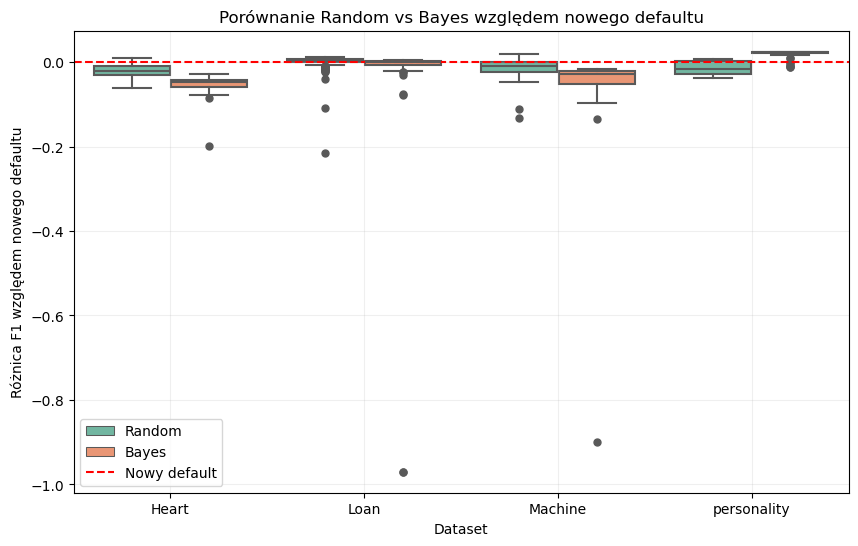

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dodajemy kolumnę Method
df_random['Method'] = 'Random'
df_bayes_cv['Method'] = 'Bayes'

# Używamy F1 z odpowiednich kolumn
df_random['F1'] = df_random['F1_score']
df_bayes_cv['F1'] = df_bayes_cv['mean_test_score']

# Łączymy oba DataFrame
df_all = pd.concat([df_random[['Dataset','F1','Method']], 
                    df_bayes_cv[['Dataset','F1','Method']]], ignore_index=True)

# Obliczamy różnicę względem nowego defaultu
df_all['F1_diff'] = df_all.apply(lambda row: row['F1'] - new_default_F1[row['Dataset']], axis=1)

# Rysujemy boxplot
plt.figure(figsize=(10,6))
sns.boxplot(x="Dataset", y="F1_diff", hue="Method", data=df_all, palette="Set2",fliersize=5, flierprops=dict(marker='o', markersize=5))

# Przerywana linia 0 = nowy default
plt.axhline(0, color='r', linestyle='--', label='Nowy default')

plt.ylabel("Różnica F1 względem nowego defaultu")
plt.title("Porównanie Random vs Bayes względem nowego defaultu")
plt.grid(alpha=0.2)
plt.legend()
plt.savefig("deltaF1LightGBM.png", dpi=300, bbox_inches='tight')  # PNG
plt.show()


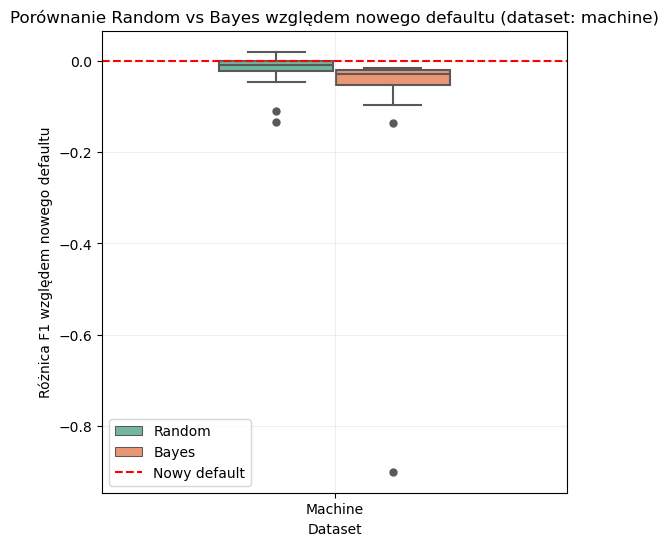

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dodajemy kolumnę Method
df_random['Method'] = 'Random'
df_bayes_cv['Method'] = 'Bayes'

# Używamy F1 z odpowiednich kolumn
df_random['F1'] = df_random['F1_score']
df_bayes_cv['F1'] = df_bayes_cv['mean_test_score']

# Filtrujemy tylko dataset "machine"
df_random_machine = df_random[df_random['Dataset'] == 'Machine']
df_bayes_machine = df_bayes_cv[df_bayes_cv['Dataset'] == 'Machine']

# Łączymy oba DataFrame
df_all = pd.concat([df_random_machine[['Dataset','F1','Method']], 
                    df_bayes_machine[['Dataset','F1','Method']]], ignore_index=True)

# Obliczamy różnicę względem nowego defaultu (tylko dataset "machine")
df_all['F1_diff'] = df_all['F1'] - new_default_F1['Machine']


plt.figure(figsize=(6,6))
sns.boxplot(x="Dataset", y="F1_diff", hue="Method", data=df_all, 
            palette="Set2", fliersize=5, flierprops=dict(marker='o', markersize=5),
            width=0.5)
plt.axhline(0, color='r', linestyle='--', label='Nowy default')
plt.ylabel("Różnica F1 względem nowego defaultu")
plt.title("Porównanie Random vs Bayes względem nowego defaultu (dataset: machine)")
plt.grid(alpha=0.2)
plt.legend()
plt.show()

